In [5]:
import pandas as pd
import requests
import pdfplumber
import re
import numpy as np
# import gspread
import csv
import time
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


# Import your pdf

This is my own path, you'd need to specifiy your personal path

In [7]:
### windows version
# pdf = pdfplumber.open(r"C:\Users\james\Dropbox\bosStatementExtraction_ghp\jpy_statement1.pdf")

### mac version
pdf = pdfplumber.open("/home/james/git/youtrip-statement-extraction/sample_youtrip_transactions.pdf")
page = pdf.pages[1]

# Find the raw bottom coordinates for fields of interest and hard code them as explicit
##### Since the "auto" detection of the horizontal rows are delinated by purple backgrounds that are inconsistent, we need to manually find bottom coordinates of each row to plot lines explicitly

In [8]:
### your regex
end_of_row = [page.search(r'¥\d{1,3}(?:,\d{3})*')]
first_line_after_header = [page.search(r'\bBalance\b')]
# end_of_row_2 = [page.search(r'$|\d')]

### (optional) crop the page using the top and bottom coordinates
# cropped_page = page.crop((451.59, 306.83000000000004, 482.15999999999997, 316.83000000000004))
# im = cropped_page.to_image()
# im

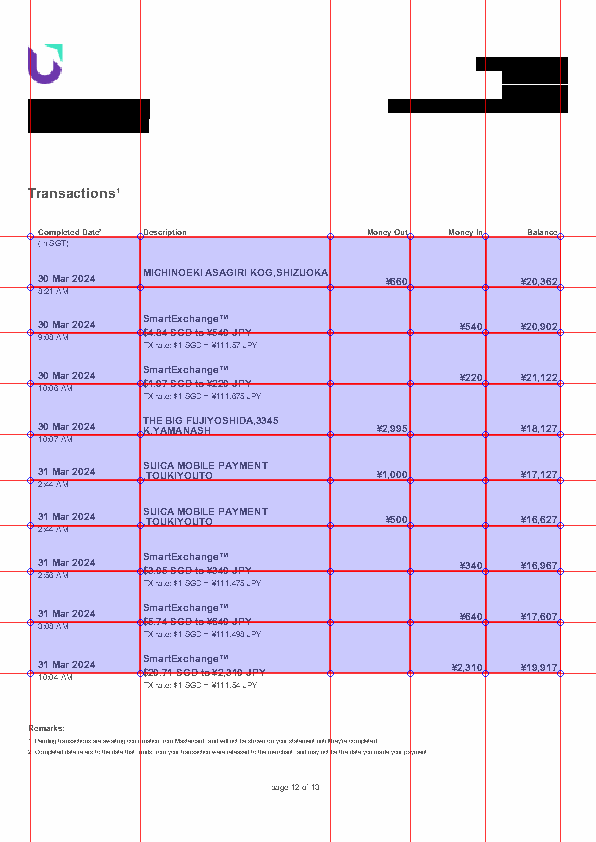

In [9]:
### quick override of the above declaration of "page" for ez debugging
### this sample only extracts one page at a time. You may choose to put this block in a loop to extract multiple pages.
page = pdf.pages[0]

row_bottom_coordinates_list = []

### we use the final jpy value at the end of each row of the "balance" column as some type of explicit delineation for horizonal line
end_of_row = [page.search(r'¥\d{1,3}(?:,\d{3})*')]

for i in range(50):
    
    try:
        # fix the issue of regex picking up values from "smartexchange" transactions and creating unneccesary lines
        # this 556.96 is the end of right hand column
        if end_of_row[0][i]['x1'] == 556.96:
            # print(end_of_row_1[0][i]['text']) # for testing
            row_bottom_coordinates = end_of_row[0][i]['bottom']
            row_bottom_coordinates_list.append(row_bottom_coordinates)

    except IndexError:
        
        break

### remove duplicated fields due to same regex identified values occuring more than once in a "row"
row_bottom_coordinates_list = list(dict.fromkeys(row_bottom_coordinates_list))

### insert a horizontal line after the header, specifically after the word "Balance"
row_bottom_coordinates_list.insert(0,first_line_after_header[0][0]['bottom'])

im = page.to_image()

im.reset().debug_tablefinder({
    "vertical_strategy": "explicit", 
    "horizontal_strategy": "explicit",
    "explicit_horizontal_lines": row_bottom_coordinates_list,
    "explicit_vertical_lines": [ 30, 140, 330, 410, 485,560],
})

As you can see from the above, it's not a perfect solution. Some transaction descriptions are cut off halfway due to the statement's inconsistent spacing. Nevertheless, the key details - such as the date, balance, money in, money out and little bits of the description are still good enough.

In [10]:
all_transactions = []

page_transactions = page.extract_table({
    "vertical_strategy": "explicit", 
    "horizontal_strategy": "explicit",
    "explicit_horizontal_lines": row_bottom_coordinates_list,
    "explicit_vertical_lines": [ 30, 140, 330, 410, 485,560],
})

for row in page_transactions:
    all_transactions.append(row)

# Fit the data into a dataframe

In [11]:
df_transactions = pd.DataFrame(all_transactions, columns=['date', 'description', 'money out', 'money in', 'balance'])
df_transactions

,date,description,money out,money in,balance
0,(in SGT)\n30 Mar 2024,"MICHINOEKI ASAGIRI KOG,SHIZUOKA",¥660,,"¥20,362"
1,8:21 AM\n30 Mar 2024,SmartExchange™,,¥540,"¥20,902"
2,9:08 AM\n30 Mar 2024,$4.84 SGD to ¥540 JPY\nFX rate: $1 SGD = ¥111....,,¥220,"¥21,122"
3,10:06 AM\n30 Mar 2024,$1.97 SGD to ¥220 JPY\nFX rate: $1 SGD = ¥111....,"¥2,995",,"¥18,127"
4,10:07 AM\n31 Mar 2024,"SUICA MOBILE PAYMENT\n,TOUKIYOUTO","¥1,000",,"¥17,127"
5,2:44 AM\n31 Mar 2024,"SUICA MOBILE PAYMENT\n,TOUKIYOUTO",¥500,,"¥16,627"
6,2:44 AM\n31 Mar 2024,SmartExchange™,,¥340,"¥16,967"
7,2:56 AM\n31 Mar 2024,$3.05 SGD to ¥340 JPY\nFX rate: $1 SGD = ¥111....,,¥640,"¥17,607"
8,3:08 AM\n31 Mar 2024,$5.74 SGD to ¥640 JPY\nFX rate: $1 SGD = ¥111....,,"¥2,310","¥19,917"


# Clean the data 

In [12]:
# Apply a custom function to split the string only if it contains '\n'
def split_string(cell):
    if '\n' in cell:
        return cell.split('\n')[1]
    else:
        return cell


df_transactions['date'] = df_transactions['date'].apply(split_string)
df_transactions['description'] = df_transactions['description'].apply(split_string)
df_transactions['money out'] = df_transactions['money out'].apply(split_string)
df_transactions['money in'] = df_transactions['money in'].apply(split_string)
df_transactions['balance'] = df_transactions['balance'].apply(split_string)

df_transactions

,date,description,money out,money in,balance
0,30 Mar 2024,"MICHINOEKI ASAGIRI KOG,SHIZUOKA",¥660,,"¥20,362"
1,30 Mar 2024,SmartExchange™,,¥540,"¥20,902"
2,30 Mar 2024,FX rate: $1 SGD = ¥111.57 JPY,,¥220,"¥21,122"
3,30 Mar 2024,FX rate: $1 SGD = ¥111.675 JPY,"¥2,995",,"¥18,127"
4,31 Mar 2024,",TOUKIYOUTO","¥1,000",,"¥17,127"
5,31 Mar 2024,",TOUKIYOUTO",¥500,,"¥16,627"
6,31 Mar 2024,SmartExchange™,,¥340,"¥16,967"
7,31 Mar 2024,FX rate: $1 SGD = ¥111.475 JPY,,¥640,"¥17,607"
8,31 Mar 2024,FX rate: $1 SGD = ¥111.498 JPY,,"¥2,310","¥19,917"


# Export as CSV

In [13]:
df_transactions.to_csv('youtrip_jpy_txn_1.csv', index=False)
print("CSV file has been exported successfully.")

CSV file has been exported successfully.
